<a href="https://colab.research.google.com/github/yeonsub/Learning_Material_for_Creation/blob/main/latent_diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Latent Diffusion Model
This notebook is a companion to [this blog post](https://nicktasios.nl/posts/latent-diffusion-series-diffusion-model/) and implements a simple latent diffusion model.

## Data Loading and Initialization

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import torch
from torch.nn.functional import cross_entropy
from torchvision.datasets import MNIST
import math
from itertools import chain
import os
import scipy

Start by setting up some plotting defaults

In [ ]:
plot_alpha = 0.0
is_dark = True
if is_dark:
    pyplot_context = 'dark_background'
    binary_cmap = LinearSegmentedColormap.from_list(name='binary_alpha', colors=[(0,0,0,plot_alpha), (1,1,1,1)])
else:
    pyplot_context = 'default'
    binary_cmap = LinearSegmentedColormap.from_list(name='binary_alpha', colors=[(1,1,1,1), (0,0,0,plot_alpha)])

We then check if cuda is available and disable gradient calculations for the time being as we explore.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Get the mnist dataset

In [ ]:
data_train = MNIST('.', download=True, train=True)
data_test  = MNIST('.', download=True, train=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 19.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 499kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.34MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.99MB/s]


Normalize the dataset such that pixel values are between -1 and 1 and pad the images to make them 32x32.

In [ ]:
# Here we normalize the mnist image values to lie between -1 and 1.
x_train = 2.0 * (data_train.data / 255.0 - 0.5)
x_val   = 2.0 * (data_test.data / 255.0 - 0.5)
y_train = data_train.targets
y_val   = data_test.targets

# We also pad the images with a 2 pixel border so that they are 32x32.
# This makes it easier to work with the convnet we define later.
x_train = torch.nn.functional.pad(x_train, (2,2,2,2), value=-1)[...,None]
x_val   = torch.nn.functional.pad(x_val, (2,2,2,2), value=-1)[...,None]

## Diffusion Model Setup

### Variational Encoder and Latent Variable Dataset

To train the latent diffusion model we first need to generate latents for our MNIST dataset. We will generate the latents using the VAE we trained in the [previous notebook](https://colab.research.google.com/drive/18UReo17EOUNYoEqVwazgS-JgXjbgOKmr#scrollTo=T3ABhvmL3y1_). To make it easy for you, I included the VAE definition and training code in this notebook.

In [ ]:
class ConvBlock(torch.nn.Module):
    def __init__(self, fin, fout, *args, **kwargs):
        super(ConvBlock, self).__init__()
        self._conv = torch.nn.Conv2d(fin, fout, *args, **kwargs)
        self._norm = torch.nn.BatchNorm2d(fout)
        self._relu = torch.nn.LeakyReLU()

    def forward(self, x):
        return self._relu(self._norm(self._conv(x)))

class ConvEncoder(torch.nn.Module):
    def __init__(self, features):
        super(ConvEncoder, self).__init__()

        layers   = []
        for i in range(len(features)-1):
            fi = features[i]
            fo = features[i+1]
            if i > 0:
                layers.append(torch.nn.Sequential(
                    torch.nn.MaxPool2d(2),
                    ConvBlock(fi, fo, 3, padding='same'),
                    ConvBlock(fo, fo, 3, padding='same'),
                ))
            else:
                layers.append(torch.nn.Sequential(
                    ConvBlock(fi, fo, 3, padding='same'),
                    ConvBlock(fo, fo, 3, padding='same'),
                ))
        self.features = features
        self.layers = torch.nn.ModuleList(layers)


    def forward(self, x):
        y = torch.clone(x)
        for layer in self.layers:
            y = layer(y)
        return y

class ConvDecoder(torch.nn.Module):
    def __init__(self, features):
        super(ConvDecoder, self).__init__()

        layers = []
        for i in range(len(features)-1):
            layer = []

            fi = features[i]
            fo = features[i+1]

            if i > 0:
                layer += [
                    torch.nn.Upsample(scale_factor=2),#, mode='bilinear'),
                    ConvBlock(fi, fi, 3, padding='same'),
                ]

            if i < len(features)-2:
                layer += [
                    ConvBlock(fi, fi, 3, padding='same'),
                    ConvBlock(fi, fo, 3, padding='same'),
                ]
            else:
                layer += [
                    ConvBlock(fi, fi, 3, padding='same'),
                    torch.nn.Conv2d(fi, fo, 3, padding='same'),
                ]


            layers.append(torch.nn.Sequential(*layer))

        self.layers = torch.nn.ModuleList(layers)


    def forward(self, x):
        y = torch.clone(x)
        for layer in self.layers:
            y = layer(y)
        return y

Let's define some parameters for the VAE

In [ ]:
features = [1, 8, 16, 32]
latent_channels = 2
batch_size    = 128
learning_rate = 1e-3
num_epochs    = 200

latent_resolution = x_train.shape[1] // (1 << (len(features) - 1))
latent_shape = (latent_channels, latent_resolution, latent_resolution)

If you have already trained the VAE, uncomment the code to load it. Be sure you skip the training, otherwise you'll have to reload it.

In [ ]:
# # If your VAE is saved to the local drive, you can skip loading it from your google drive.
# from google.colab import drive
# drive.mount('/content/drive')
# !cp "/content/drive/MyDrive/Colab Notebooks/autoencoder/variational_encoder.pt" .
# !cp "/content/drive/MyDrive/Colab Notebooks/autoencoder/variational_decoder.pt" .

# encoder = ConvEncoder(features + [2 * latent_channels,])
# decoder = ConvDecoder([latent_channels,] + features[::-1])

# print('Number of parameters:', np.sum([torch.numel(x) for x in list(chain(encoder.parameters(),decoder.parameters()))]))

# encoder.load_state_dict(torch.load('variational_encoder.pt', map_location=device))
# decoder.load_state_dict(torch.load('variational_decoder.pt', map_location=device))
# encoder = encoder.to(device)
# decoder = decoder.to(device)

Let us now create the VAE and train it.

In [ ]:
encoder = ConvEncoder(features + [2 * latent_channels,])
decoder = ConvDecoder([latent_channels,] + features[::-1])
optimizer = torch.optim.Adam(chain(encoder.parameters(), decoder.parameters()), learning_rate)

print('Number of parameters:', np.sum([torch.numel(x) for x in list(chain(encoder.parameters(),decoder.parameters()))]))

encoder = encoder.to(device)
decoder = decoder.to(device)

Number of parameters: 50731


In [ ]:
print_every = 10
num_batches = int(math.ceil(x_train.shape[0] / batch_size))
encoder.train()
decoder.train()

avg_loss = 0.0
mean_rec = 0.0
mean_kl  = 0.0
for i in range(num_epochs):
    train_ids = torch.randperm(x_train.shape[0])
    for bid in range(num_batches):
        with torch.no_grad():
            batch_ids = train_ids[bid*batch_size:(bid+1)*batch_size]
            x = x_train[batch_ids,...]
            x = x.to(device)
            x = torch.transpose(x, 1, 3)

        mu_sigma = encoder(x)
        mu    = mu_sigma[:,:latent_channels,:,:]
        sigma = mu_sigma[:,latent_channels:,:,:]
        z = torch.normal(0, 1, size=mu.shape, device=device) * sigma + mu
        new_x = decoder(z)

        reconstruction_loss = torch.sum((new_x - x)**2, dim=[1,2,3])
        sigma2 = sigma**2
        kl_loss = 0.5 * torch.sum(sigma2 + mu**2 - torch.log(sigma2) - 1.0, dim=[1,2,3])
        loss = reconstruction_loss + kl_loss
        loss = torch.mean(loss)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            avg_loss += loss.cpu().numpy() / num_batches
            mean_rec += torch.mean(reconstruction_loss).cpu().numpy() / num_batches
            mean_kl  += torch.mean(kl_loss).cpu().numpy() / num_batches

    if (i + 1) % print_every == 0:
      print(i, avg_loss / print_every, mean_rec / print_every, mean_kl / print_every)
      avg_loss = 0.0
      mean_rec = 0.0
      mean_kl  = 0.0


9 223.13147 132.54488 90.58626
19 219.07109 123.42916 95.642586
29 158.48749 71.67794 86.809616
39 161.33078 65.92396 95.40683
49 131.19138 44.711235 86.47981
59 146.59055 48.948425 97.64205
69 127.878555 36.549416 91.32912
79 114.53072 33.94494 80.585724
89 105.93367 33.75991 72.17379
99 105.27641 32.468025 72.80839
109 98.92184 33.050484 65.871475
119 91.5591 33.7795 57.779743
129 86.17576 34.15019 52.025513
139 82.306 34.476448 47.829506
149 79.39006 34.596153 44.79406
159 77.18584 34.67598 42.50993
169 75.452675 34.7194 40.73336
179 74.07015 34.74681 39.323364
189 72.94627 34.71976 38.226376
199 72.02255 34.663296 37.359135


Let's now save the model, and optionally copy the saved model to your google drive.

In [ ]:
torch.save(encoder.state_dict(), 'variational_encoder.pt')
torch.save(decoder.state_dict(), 'variational_decoder.pt')

# Optionally, copy the model to your google drive so you can retrieve it later.
from google.colab import drive
drive.mount('/content/drive', force_remount=False)
os.makedirs('/content/drive/MyDrive/Colab Notebooks/autoencoder/', exist_ok=True)
!cp variational_encoder.pt "/content/drive/MyDrive/Colab Notebooks/autoencoder/"
!cp variational_decoder.pt "/content/drive/MyDrive/Colab Notebooks/autoencoder/"

Mounted at /content/drive


Let's now pass our dataset to the encoder to produce the latent variables. We produce two sets of data, lat_train and lat_val, corresponding to the training and validation sets respectively.

In [ ]:
# Prepare latent data for diffusion model
encoder.eval()

# Train data
num_batches = int(math.ceil(x_train.shape[0] / batch_size))
lat_train = []
with torch.no_grad():
    for bid in range(num_batches):
        x = x_train[bid*batch_size:(bid+1)*batch_size,...]
        x = x.to(device)
        x = torch.transpose(x, 1, 3)

        mu_sigma = encoder(x)
        mu    = mu_sigma[:,:latent_channels,:,:]
        sigma = mu_sigma[:,latent_channels:,:,:]
        z = torch.normal(0, 1, size=mu.shape, device=device) * sigma + mu
        lat_train.append(z.cpu())

lat_train = torch.cat(lat_train)

# Validation data
num_batches = int(math.ceil(x_val.shape[0] / batch_size))
lat_val = []
with torch.no_grad():
    for bid in range(num_batches):
        x = x_val[bid*batch_size:(bid+1)*batch_size,...]
        x = x.to(device)
        x = torch.transpose(x, 1, 3)

        mu_sigma = encoder(x)
        mu    = mu_sigma[:,:latent_channels,:,:]
        sigma = mu_sigma[:,latent_channels:,:,:]
        z = torch.normal(0, 1, size=mu.shape, device=device) * sigma + mu
        lat_val.append(z.cpu())

lat_val = torch.cat(lat_val)

Let's make sure that our model outputs what expected. Let's plot a few MNIST characters and how the VAE represents them.

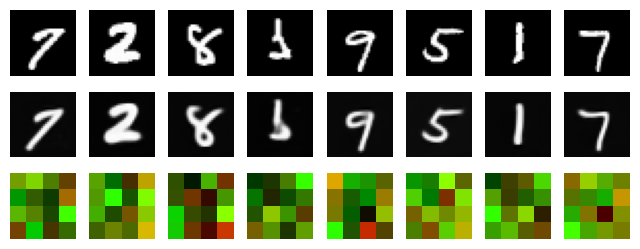

In [ ]:
fig, axes = plt.subplots(3,8, figsize=(8,3))
perm = torch.randperm(x_val.shape[0])[:8]
d = x_val[perm,...].to(device)
#d = 0.5 * (d + 1.0)
with torch.no_grad():
    encoder.eval()
    decoder.eval()

    mu_sigma = encoder(torch.transpose(d, 1, 3))
    mu    = mu_sigma[:,:latent_channels,:,:]
    sigma = mu_sigma[:,latent_channels:,:,:]
    z = torch.normal(0, 1, size=mu.shape, device=device) * sigma + mu

    pred = decoder(z)
    pred = torch.transpose(pred, 1, 3)
    lat  = torch.transpose(z, 1, 3)


for i in range(8):
    x = d[i,:,:,0].cpu().numpy()
    y = pred[i,:,:,0].cpu().numpy()
    z = lat[i,:,:,:].cpu().numpy()
    z = (z - np.min(z)) / (np.max(z) - np.min(z))
    axes[0,i].imshow(x, cmap='gray')
    axes[0,i].axis('off')
    axes[1,i].imshow(y, cmap='gray')
    axes[1,i].axis('off')
    axes[2,i].imshow(np.pad(z, [(0,0), (0,0), (0, 1)]), cmap='gray')
    axes[2,i].axis('off')
plt.show()

### Diffusion Model Architecture

Now let's build the latent diffusion model architecture. We start by defining a positional embedding for the time variable.

In [ ]:
class SinusoidalPositionEmbedding(torch.nn.Module):
    def __init__(self, dim=16, scale=10000.0):
        super().__init__()
        half_dim = dim // 2
        emb_scale = math.log(scale) / (half_dim - 1)
        self.emb_factor = torch.exp(-emb_scale * torch.arange(half_dim, device=device))

    def forward(self, time):
        embeddings = time[:, None] * self.emb_factor[None,:]
        return torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)

In [ ]:
class TimeEmbeddingConvBlock(torch.nn.Module):
    def __init__(self, fin, fout, tin, *args, **kwargs):
        super(TimeEmbeddingConvBlock, self).__init__()
        self._conv = torch.nn.Conv2d(fin, fout, *args, **kwargs)
        self._norm = torch.nn.InstanceNorm2d(fout)
        self._relu = torch.nn.LeakyReLU()
        self._emb_linear = torch.nn.Linear(tin, fout)

    def forward(self, x, t_emb):
        t_emb = self._emb_linear(self._relu(t_emb))
        x = self._conv(x)
        return self._relu(self._norm(x) + t_emb[:,:,None,None])

class TimeEmbeddingEncoder(torch.nn.Module):
    def __init__(self, features, time_embedding_dim):
        super(TimeEmbeddingEncoder, self).__init__()

        ted = time_embedding_dim
        layers   = []
        for i in range(len(features)-1):
            fi = features[i]
            fo = features[i+1]
            if i > 0:
                layers.append(torch.nn.ModuleList([
                    torch.nn.MaxPool2d(2),
                    TimeEmbeddingConvBlock(fi, fo, ted, 3, padding='same'),
                    TimeEmbeddingConvBlock(fo, fo, ted, 3, padding='same'),
                ]))
            else:
                layers.append(torch.nn.ModuleList([
                    TimeEmbeddingConvBlock(fi, fo, ted, 3, padding='same'),
                    TimeEmbeddingConvBlock(fo, fo, ted, 3, padding='same'),
                ]))
        self.features = features
        self.layers = torch.nn.ModuleList(layers)


    def forward(self, x, t_emb):
        y = x
        values = []
        for layer in self.layers:
            for module in layer:
                y = module(y, t_emb) if isinstance(module, TimeEmbeddingConvBlock) else module(y)
            values.append(y)
        return values

class TimeEmbeddingDecoder(torch.nn.Module):
    def __init__(self, features, time_embedding_dim):
        super(TimeEmbeddingDecoder, self).__init__()

        ted = time_embedding_dim
        layers   = []
        for i in range(len(features)):
            layer = []

            if i > 0:
                fi = features[i-1]
                fo = features[i]
                layer += [
                    TimeEmbeddingConvBlock(fi, fo, ted, 3, padding='same'),
                    TimeEmbeddingConvBlock(fo, fo, ted, 3, padding='same'),
                ]

            if i < (len(features)-1):
                fi = features[i]
                fo = features[i+1]
                layer += [
                    torch.nn.Upsample(scale_factor=2),#, mode='bilinear'),
                    TimeEmbeddingConvBlock(fi, fo, ted, 3, padding='same'),
                ]

            layers.append(torch.nn.ModuleList(layer))

        self.layers = torch.nn.ModuleList(layers)


    def forward(self, xs, t_emb):
        xs = xs[::-1]
        for li, layer in enumerate(self.layers):
            y = torch.cat((xs[li], y), dim=1) if li > 0 else xs[li]
            for module in layer:
                y = module(y, t_emb) if isinstance(module, TimeEmbeddingConvBlock) else module(y)
        return y

class TimeEmbeddingModel(torch.nn.Module):
    def __init__(self, features, time_steps, num_channels=1, time_embedding_dim=16):
        super(TimeEmbeddingModel, self).__init__()

        self.encoder = TimeEmbeddingEncoder([num_channels,] + features, time_embedding_dim)
        self.decoder = TimeEmbeddingDecoder(features[::-1], time_embedding_dim)
        self.output_layer = torch.nn.Conv2d(features[0], num_channels, 1, padding='same')
        self.time_embedding = torch.nn.Sequential(
            SinusoidalPositionEmbedding(time_embedding_dim),
            torch.nn.Linear(time_embedding_dim, time_embedding_dim),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(time_embedding_dim, time_embedding_dim)
        )


    def forward(self, x, t):
        t_emb = self.time_embedding(t)
        y = self.encoder(x, t_emb)
        y = self.decoder(y, t_emb)
        y = self.output_layer(y)
        return y


Let us prepare the variables for the diffusion model

In [ ]:
unet_features = [32, 64]
time_embedding_dim = 128
time_steps    = 1000
batch_size    = 128
learning_rate = 1e-3
num_epochs    = 200

### Variance Schedule

We now turn our attention to the variance schedule for the model. There are different options here. Below you can see a comparison between two popular ones, a cosine and a linear schedule.

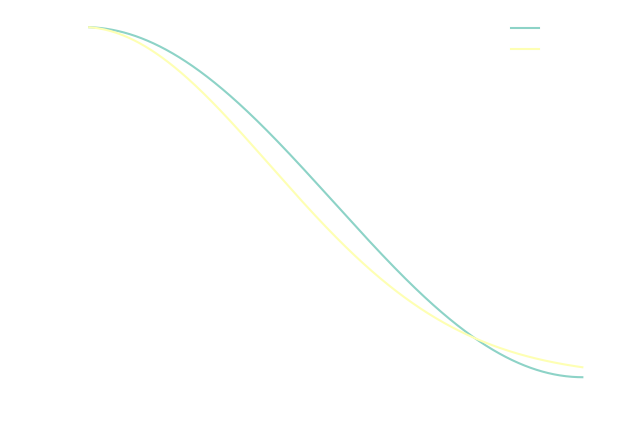

In [ ]:
def make_cosine_schedule(num_timesteps, s=0.008):
    t = torch.arange(num_timesteps+1)
    alpha_prod = torch.cos(0.5 * (t / (num_timesteps+1) + s) / (1.0 + s) * math.pi)**2
    alpha_prod = alpha_prod / alpha_prod[0]
    return alpha_prod[1:]

def make_linear_schedule(num_timesteps=1000, start=1e-4, end=7e-3):
    betas = torch.linspace(start, end, num_timesteps)
    alpha_prod = torch.cumprod(1.0 - betas, dim=-1)
    return alpha_prod

alpha_prod_cos = make_cosine_schedule(time_steps)
alpha_prod_lin = make_linear_schedule(time_steps)
with plt.style.context(pyplot_context):
    fig, axes = plt.subplots(figsize=(7,5))
    plt.plot(alpha_prod_cos, label='cosine')
    plt.plot(alpha_prod_lin, label='linear')
    plt.xlabel(r'$t$')
    plt.ylabel(r'$\bar{\alpha}_t$')
    plt.legend(frameon=False)
    axes.patch.set_alpha(plot_alpha)
    fig.patch.set_alpha(plot_alpha)
    plt.show()

In my experience, for small problems like the MNIST, the linear schedule seems to be a bit better, although the cosine model can also work fine if you increase the parameter, $s$, significantly.

Here I will choose the linear schedule for the rest of the Notebook, but do experiment with it.

In [ ]:
alpha_prod = alpha_prod_lin

Now let's check how diffusion affects MNIST samples with a linear schedule.

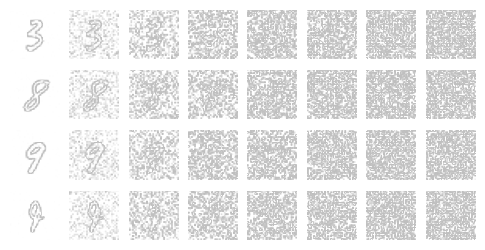

In [ ]:
fig_shape = np.array([4, 8]) # rows, columns
fig_size  = tuple(fig_shape[::-1] * 0.75)

# Setup fig_shape[1] uniformly spaced time steps. We clamp the last step to
# time_steps.
t = (torch.arange(fig_shape[1]) / (fig_shape[1] - 1) * time_steps).int()
t = torch.maximum(torch.ones_like(t), t)
t = t.repeat(fig_shape[0],1).T.reshape(-1)

# Sample fig_shape[0] digits from the validation set.
perm = np.random.choice(np.arange(x_val.shape[0]), fig_shape[0], replace=False)
x_0 = x_val[perm]
x_0 = x_0.repeat(fig_shape[1],1,1,1)

# Sample the noise for the diffusion process
N = torch.normal(0, 1, size=x_0.shape)

# Forward diffusion
ap = alpha_prod[t-1].view(-1,1,1,1)
x_t = torch.sqrt(ap) * x_0 + torch.sqrt(1.0 - ap) * N

# Plot samples
with plt.style.context(pyplot_context):
    fig, axes = plt.subplots(fig_shape[0], fig_shape[1], figsize=fig_size)
    for i in range(fig_shape[0] * fig_shape[1]):
        img = np.clip(0.5 * (x_t[i,:,:,0] + 1.0), 0.0, 1.0)
        ai, aj = (i  % fig_shape[0], i // fig_shape[0])
        axes[ai,aj].imshow(img, cmap=binary_cmap)
        axes[ai,aj].axis('off')
        axes[ai,aj].patch.set_alpha(plot_alpha)
    fig.patch.set_alpha(plot_alpha)
    plt.show()

### Training the Model

To help us with the training, let us create a function that will take as input the model, a sampled latent, $x_0$, and a time $t \in [1,T]$, and calculating the corresponding prediction error (loss) of the model from the diffused sample, $x_t$.

@todo: Perhaps some equations for sampling here?

In [ ]:
def do_step(model, x_0, t):
    eps = torch.normal(0, 1, size=x_0.shape, device=device)

    ap = alpha_prod[t-1].view(-1,1,1,1)
    x_t = torch.sqrt(ap) * x_0 + torch.sqrt(1.0 - ap) * eps

    eps_theta = model(x_t, t)
    loss = torch.nn.functional.mse_loss(eps, eps_theta)

    return loss

With this, we have all required components to create our model and start training it on the diffusion process.

In [ ]:
model = TimeEmbeddingModel(unet_features, time_steps, latent_channels, time_embedding_dim=time_embedding_dim)
# from google.colab import drive
# drive.mount('/content/drive', force_remount=False)
# !cp "/content/drive/MyDrive/Colab Notebooks/diffusion/diffusion_model.pt" .
# model.load_state_dict(torch.load('diffusion_model.pt', map_location=device))
model = model.to(device)
print('Number of parameters:', np.sum([torch.numel(x) for x in list(model.parameters())]))

Number of parameters: 181698


In [ ]:
alpha_prod = alpha_prod.to(device)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), learning_rate)

i_log = 10
num_batches = int(math.ceil(lat_train.shape[0] / batch_size))
num_batches_val = int(math.ceil(lat_val.shape[0] / batch_size))

losses = []
for i in range(num_epochs):
    model.train()
    train_ids = torch.randperm(lat_train.shape[0])
    average_loss = 0.0
    for bid in range(num_batches):

        with torch.no_grad():
            batch_ids = train_ids[bid*batch_size:(bid+1)*batch_size]
            x = lat_train[batch_ids,...]
            x = x.to(device)
            t = torch.randint(1, time_steps+1, (x.shape[0],), device=device)

        loss = do_step(model, x, t)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            average_loss += loss.cpu().numpy() / num_batches

    if (i + 1) % i_log == 0:
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for bid in range(num_batches_val):
                x = lat_val[bid*batch_size:(bid+1)*batch_size,...].to(device)
                t = torch.randint(1, time_steps+1, (x.shape[0],), device=device)
                loss = do_step(model, x, t)
                val_loss += loss.cpu().numpy()

        val_loss /= num_batches_val
        losses.append([average_loss, val_loss])
        print(f'Epoch {i} loss = {average_loss}, val_loss = {val_loss}')


Epoch 9 loss = 0.3699871003627777, val_loss = 0.36373138427734375
Epoch 19 loss = 0.35895979404449463, val_loss = 0.3642122149467468
Epoch 29 loss = 0.3581750988960266, val_loss = 0.3552614450454712
Epoch 39 loss = 0.3559706509113312, val_loss = 0.35650578141212463
Epoch 49 loss = 0.35161861777305603, val_loss = 0.35663291811943054
Epoch 59 loss = 0.3510216474533081, val_loss = 0.3458881080150604
Epoch 69 loss = 0.3510548770427704, val_loss = 0.3478935956954956
Epoch 79 loss = 0.35100430250167847, val_loss = 0.3506995439529419
Epoch 89 loss = 0.3512941002845764, val_loss = 0.351811021566391
Epoch 99 loss = 0.3494270443916321, val_loss = 0.35291045904159546
Epoch 109 loss = 0.3473655879497528, val_loss = 0.35133275389671326
Epoch 119 loss = 0.3487270772457123, val_loss = 0.3488534092903137
Epoch 129 loss = 0.3492307960987091, val_loss = 0.3473838269710541
Epoch 139 loss = 0.3486005365848541, val_loss = 0.3438078463077545
Epoch 149 loss = 0.3494338393211365, val_loss = 0.3467593491077423

Save the model and optionally copy to google drive

In [ ]:
torch.save(model.state_dict(), 'diffusion_model.pt')

# Optionally, copy the model to your google drive so you can retrieve it later.
from google.colab import drive
drive.mount('/content/drive', force_remount=False)
os.makedirs('/content/drive/MyDrive/Colab Notebooks/diffusion/', exist_ok=True)
!cp diffusion_model.pt "/content/drive/MyDrive/Colab Notebooks/diffusion/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Diffusion Model Evaluation

### Training and Validation Loss
Let us first have a look how our model did during training.

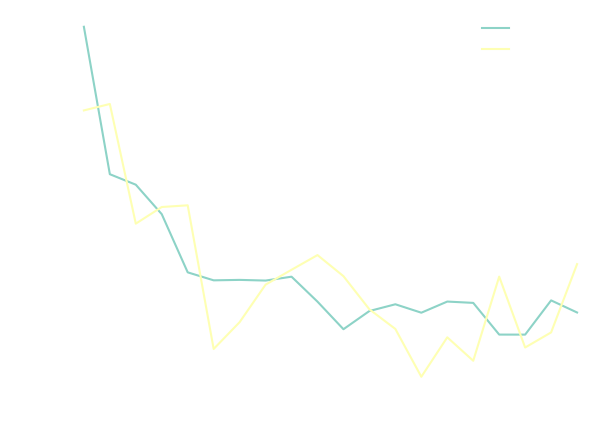

In [ ]:
losses = np.array(losses)
x = np.arange(losses.shape[0]) * i_log
with plt.style.context(pyplot_context):
    fig, axes = plt.subplots(figsize=(7,5))
    axes.plot(x, losses[:,0], label='train')
    axes.plot(x, losses[:,1], label='validation')
    axes.patch.set_alpha(plot_alpha)
    fig.patch.set_alpha(plot_alpha)
    axes.legend(frameon=False)

### Model Sampling

Here some things about how sampling works?

In [ ]:
def do_diffusion_backward(model, x, time_steps):
    x_t = torch.clone(x)

    for t in range(time_steps,0,-1):
        a  = alpha_prod[t-1] / alpha_prod[t-2] if t > 1 else alpha_prod[0]
        ap = alpha_prod[t-1].view(-1,1,1,1)

        eps_theta = model(x_t, t * torch.ones(x.shape[0], device=device).int())
        x_t = (1.0 / torch.sqrt(a)) * (x_t - ((1.0 - a) / torch.sqrt(1.0 - ap)) * eps_theta)
        if t > 1:
            ap_prev = alpha_prod[t-2].view(-1,1,1,1)
            sigma = torch.sqrt(((1.0 - ap_prev) / (1.0 - ap)) * (1.0 - a))
            N = torch.normal(torch.zeros_like(x, device=device), torch.ones_like(x, device=device))
            x_t += N * sigma

    return x_t

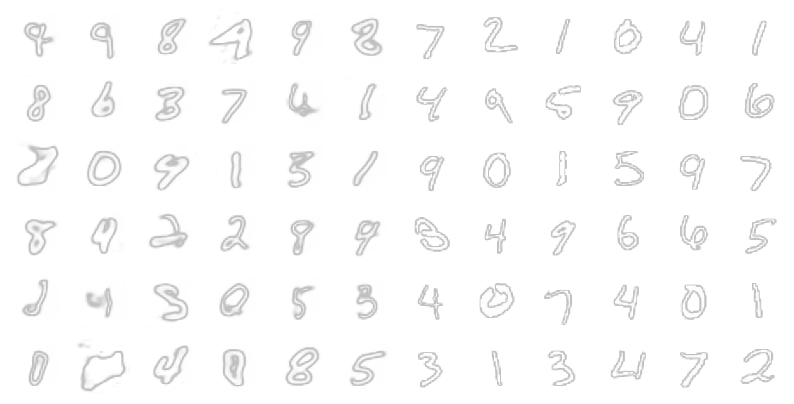

In [ ]:
with torch.no_grad():
    model.eval()
    eval_shape = (2*36,) + lat_val.shape[1:]
    N = torch.randn(eval_shape, device=device)
    pred = do_diffusion_backward(model, N, time_steps)

    decoder.eval()
    pred = decoder(pred).cpu().numpy()

    with plt.style.context(pyplot_context):
        fig, axes = plt.subplots(6,2*6, figsize=(2*5,5))
        for i in range(36):
            img = np.clip(pred[i,0,:,:].T, -1.0, 1.0)
            axes[i//6,i%6].imshow(img, cmap=binary_cmap)
            axes[i//6,i%6].axis('off')
            axes[i//6,i%6].patch.set_alpha(plot_alpha)
        for i in range(36):
            img = np.clip(x_val[i,:,:,0], -1.0, 1.0)
            axes[i//6,6+i%6].imshow(img, cmap=binary_cmap)
            axes[i//6,6+i%6].axis('off')
            axes[i//6,6+i%6].patch.set_alpha(plot_alpha)
        fig.patch.set_alpha(plot_alpha)
        plt.show()


### Fréchet inception distance

The Fréchet distance is a measure of simlarity of two distributions. For two multidimensional Gaussian distributions, the distance is calculated as,
$$
d_F = \left| \mu_A - \mu_B \right|^2 + tr( \Sigma_A + \Sigma_B - 2 \sqrt{\Sigma_A \Sigma_B} )
$$
The Fréchet *inception* distance compares the output of the last layer before the classification layer of [inceptionv3](https://en.wikipedia.org/wiki/Inceptionv3). Here, instead, we use a much simplified classifier.

In [ ]:
class Classifier(torch.nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()

        self.layers = torch.nn.Sequential(
            # 1x32x32
            torch.nn.Conv2d(1, 8, 3, padding='same'),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, 2),

            # 8x16x16
            torch.nn.Conv2d(8, 16, 3, padding='same'),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, 2),

            # 16x8x8
            torch.nn.Conv2d(16, 32, 3, padding='same'),
            torch.nn.ReLU(),
            torch.nn.AvgPool2d(4, 4),

            # 32x2x2
            torch.nn.Flatten(),
            torch.nn.Dropout(),
        )

        self.classification_layer = torch.nn.Sequential(
            torch.nn.Linear(128, 10),
        )

    def forward(self, x):
        y = self.layers(x)
        y = self.classification_layer(y)
        return y


In [ ]:
# # If your Classifier is saved to the local drive, you can skip loading it from your google drive.
# from google.colab import drive
# drive.mount('/content/drive', force_remount=False)
# !cp "/content/drive/MyDrive/Colab Notebooks/classifier/classifier.pt" .

# classifier = Classifier()
# classifier.load_state_dict(torch.load('classifier.pt', map_location=device))
# classifier.to(device)

In [ ]:
classifier = Classifier()
classifier = classifier.to(device)

In [ ]:
optimizer = torch.optim.Adam(classifier.parameters(), learning_rate)

i_log = 10
num_batches = int(math.ceil(lat_train.shape[0] / batch_size))
num_batches_val = int(math.ceil(lat_val.shape[0] / batch_size))

losses = []
for i in range(num_epochs):
    model.train()
    train_ids = torch.randperm(lat_train.shape[0])
    average_loss = 0.0
    for bid in range(num_batches):

        with torch.no_grad():
            batch_ids = train_ids[bid*batch_size:(bid+1)*batch_size]
            x = x_train[batch_ids,None,...,0]
            y = y_train[batch_ids,...]
            y = y.to(device)
            x = x.to(device)

        y_pred = classifier(x)
        loss = cross_entropy(y_pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            average_loss += loss.cpu().numpy() / num_batches

    if (i + 1) % i_log == 0:
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for bid in range(num_batches_val):
                y = y_val[bid*batch_size:(bid+1)*batch_size,...].to(device)
                x = x_val[bid*batch_size:(bid+1)*batch_size,None,...,0].to(device)
                y_pred = classifier(x)
                loss = cross_entropy(y_pred, y)
                val_loss += loss.cpu().numpy()

        val_loss /= num_batches_val
        losses.append([average_loss, val_loss])
        print(f'Epoch {i} loss = {average_loss}, val_loss = {val_loss}')


Epoch 9 loss = 0.1303023099899292, val_loss = 0.1165899932384491
Epoch 19 loss = 0.09074371308088303, val_loss = 0.08039186149835587
Epoch 29 loss = 0.07394078373908997, val_loss = 0.07364456355571747
Epoch 39 loss = 0.06824889779090881, val_loss = 0.06688516587018967
Epoch 49 loss = 0.06298872828483582, val_loss = 0.06634188443422318
Epoch 59 loss = 0.058917783200740814, val_loss = 0.06215653941035271
Epoch 69 loss = 0.054139718413352966, val_loss = 0.06286278367042542
Epoch 79 loss = 0.05069854483008385, val_loss = 0.058813150972127914
Epoch 89 loss = 0.04685147851705551, val_loss = 0.05656829848885536
Epoch 99 loss = 0.04756343737244606, val_loss = 0.055544413626194
Epoch 109 loss = 0.04559702426195145, val_loss = 0.05680788680911064
Epoch 119 loss = 0.04078727588057518, val_loss = 0.05758505314588547
Epoch 129 loss = 0.04087510704994202, val_loss = 0.06152762472629547
Epoch 139 loss = 0.03857070580124855, val_loss = 0.06215770170092583
Epoch 149 loss = 0.040280237793922424, val_los

In [ ]:
classifier.eval()
with torch.no_grad():
    y_val_pred = classifier(x_val[:,None,...,0].to(device)).cpu().numpy()

accuracy = np.mean(np.argmax(y_val_pred, axis=-1) == y_val.numpy())
print(f'Model accuracy: {100.0 * accuracy:.2f}%')

Model accuracy: 99.10%


In [ ]:
torch.save(model.state_dict(), 'classifier.pt')
# Optionally copy the saved model to your google drive.
from google.colab import drive
drive.mount('/content/drive', force_remount=False)
os.makedirs('/content/drive/MyDrive/Colab Notebooks/classifier/', exist_ok=True)
!cp classifier.pt "/content/drive/MyDrive/Colab Notebooks/classifier/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Let us use the diffusion model to generate a synthetic dataset with size equal to the validation set.

In [ ]:
batch_size_eval = 1024
num_batches_val = int(math.ceil(x_val.shape[0] / batch_size_eval))

x_gen = []
x_gen_vae = []
with torch.no_grad():
    model.eval()
    decoder.eval()
    for bi in range(num_batches_val):
        print(bi)
        size = batch_size_eval
        if bi == num_batches_val - 1:
            size = x_val.shape[0] - bi * batch_size_eval

        eval_shape = (size,) + lat_val.shape[1:]
        N = torch.normal(0, 1, eval_shape, device=device)
        pred = do_diffusion_backward(model, N, time_steps)
        pred = decoder(pred).cpu().numpy()
        x_gen.append(pred)

        z = torch.normal(0, 1.0, size=(size, latent_channels, 4, 4), device=device)
        pred = decoder(z).cpu().numpy()
        x_gen_vae.append(pred)

x_gen     = np.concatenate(x_gen)
x_gen_vae = np.concatenate(x_gen_vae)

0
1
2
3
4
5
6
7
8
9


We will now use the classifier to evaluate the layer before classification for our generated dataset, as well as for the validation and training dataset. We also create one with random values to compare to in the end.

In [ ]:
classifier.eval()
with torch.no_grad():
    x = x_val[:,None,:,:,0].to(device)
    latent_val = classifier.layers(x)

    x = x_train[:,None,:,:,0].to(device)
    latent_train = classifier.layers(x)

    x = torch.from_numpy(x_gen).to(device)
    x = torch.transpose(x, 2, 3)
    latent_gen = classifier.layers(x)

    x = torch.from_numpy(x_gen_vae).to(device)
    x = torch.transpose(x, 2, 3)
    latent_gen_vae = classifier.layers(x)

    latent_rand = torch.randn(latent_gen.shape, device=device)
    mu    = torch.std(latent_train, dim=0)
    sigma = torch.mean(latent_train, dim=0)
    latent_rand = latent_rand * mu + sigma

Applying the classification layer to the latent variables, we can evaluate the labels for the different datasets.

In [ ]:
labels_gen     = torch.argmax(torch.nn.functional.softmax(classifier.classification_layer(latent_gen), dim=-1), dim=-1).cpu().numpy()
labels_gen_vae = torch.argmax(torch.nn.functional.softmax(classifier.classification_layer(latent_gen_vae), dim=-1), dim=-1).cpu().numpy()
labels_val     = torch.argmax(torch.nn.functional.softmax(classifier.classification_layer(latent_val), dim=-1), dim=-1).cpu().numpy()
labels_train   = torch.argmax(torch.nn.functional.softmax(classifier.classification_layer(latent_train), dim=-1), dim=-1).cpu().numpy()
labels_rand    = torch.argmax(torch.nn.functional.softmax(classifier.classification_layer(latent_rand), dim=-1), dim=-1).cpu().numpy()

Let's plot a historgram of the generated and validation set labels and see how close the distributions are.

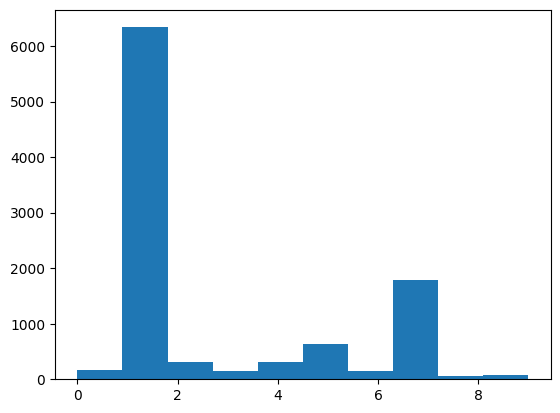

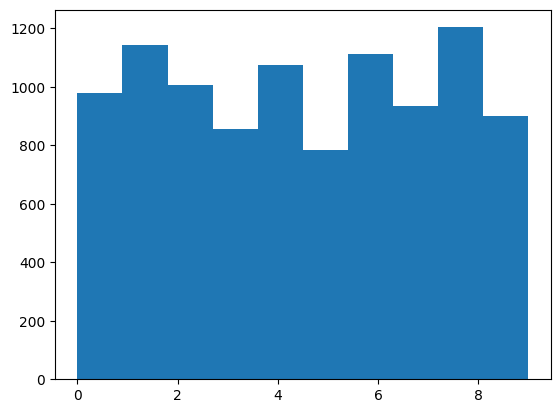

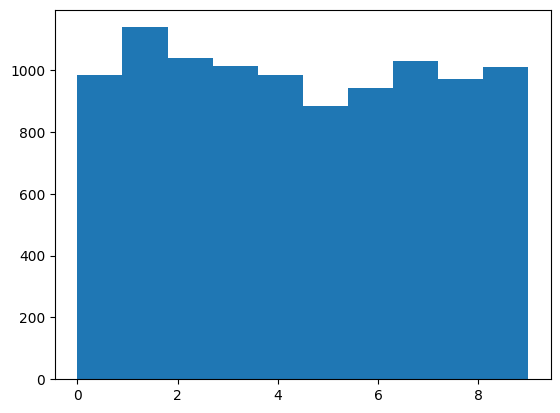

In [ ]:
plt.hist(labels_gen_vae)
plt.show()
plt.hist(labels_gen)
plt.show()
plt.hist(labels_val)
plt.show()

That's not bad, but there is definitely a difference there. Let us now evaluate the Fréchet distance!

In [ ]:
def frechet_distance(x_a, x_b):
    mu_a    = np.mean(x_a, axis=0)
    sigma_a = np.cov(x_a.T)
    mu_b    = np.mean(x_b, axis=0)
    sigma_b = np.cov(x_b.T)

    diff = mu_a - mu_b
    covmean = scipy.linalg.sqrtm(sigma_a @ sigma_b)
    return np.sum(diff**2) + np.trace(sigma_a + sigma_b - 2.0 * covmean)

In [ ]:
latent_val     = latent_val.cpu().numpy()
latent_rand    = latent_rand.cpu().numpy()
latent_gen     = latent_gen.cpu().numpy()
latent_gen_vae = latent_gen_vae.cpu().numpy()
latent_train   = latent_train.cpu().numpy()

In [ ]:
print('Random:    ', frechet_distance(latent_rand, latent_val))
print('VAE:       ', frechet_distance(latent_gen_vae, latent_val))
print('Diffusion: ', frechet_distance(latent_gen, latent_val))
print('Validation:', frechet_distance(latent_val, latent_train))

/tmp/ipython-input-3532828688.py:8: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean = scipy.linalg.sqrtm(sigma_a @ sigma_b)


Random:     42.89707144851255
VAE:        62.38797515029273
Diffusion:  5.369296408543898
Validation: 0.23926941339081625


Our generated data fair quite a bit better than random, but also the VAE. If we compare with the validation set, though, we still have room for improvement!